# Objectives

* Replicate the "Spotify Wrapped" functionality using our entire streaming history.
* Identify if there are any trends in my listening history that change over time.
* See if there are any outliers or patterns in listening history worth investigating.

# Setup

## Library Import

In [6]:
import sys
import os
import base64
import pandas as pd
import numpy as np
import json
import re
import requests
import psycopg2
import seaborn as sns
from time import time, sleep
import datetime
import matplotlib.pyplot as plt
import duckdb

from sqlalchemy import create_engine, text, Table, Column, Integer, String, MetaData, insert, update
from sqlalchemy import select, or_, and_, literal_column
from sqlalchemy.dialects.postgresql import insert as pgsql_insert
from pathlib import Path, PureWindowsPath, PurePosixPath, PurePath
from dotenv import load_dotenv

from IPython.display import display, JSON

## Configure File Paths

In [7]:
# Original
os.chdir('C:\\Users\\lover\\Documents\\Github\\Spotify_Streaming_Data_Analysis\\')

# os.chdir('C:\\Users\\lover\\Documents\\Acronis_Recovery\\Users\\lover\\Documents\\Github\\Spotify_Streaming_Data_Analysis')
os.getcwd()

'C:\\Users\\lover\\Documents\\Github\\Spotify_Streaming_Data_Analysis'

In [8]:
# Get current path
cwd = PurePath(Path.cwd())

# Construct path to archive location
data_path = cwd / 'data' / 'spotify_data' / 'Spotify Extended Streaming History'

# Construct query output path
query_output_path = cwd / 'data'/ 'sql' / 'query_results'

In [9]:
string_data_path = str(data_path)
string_data_path

'C:\\Users\\lover\\Documents\\Github\\Spotify_Streaming_Data_Analysis\\data\\spotify_data\\Spotify Extended Streaming History'

## Functions

In [10]:
def get_json_files(directory):
  """
  Returns a list of PurePath objects representing JSON files in the given directory.
  """
  json_files = []
  for filename in os.listdir(directory):
    file_path = PurePath(directory, filename)
    if file_path.is_file() and file_path.suffix == '.json':
      json_files.append(file_path)
  return json_files


# Method 2: Using Path.iterdir() with PurePath
def list_files_pathlib(path_str):
    pure_path = PurePath(path_str)
    path = Path(pure_path)
    if not path.is_dir():
        return "The specified path is not a directory."
    return [entry.name for entry in path.iterdir() if entry.is_file()]



# Method 1: Using os.listdir() with PurePath
def list_files_os(path_str):
    pure_path = PurePath(path_str)
    if not os.path.isdir(path_str):
        return "The specified path is not a directory."
        all_files =  [f for f in os.listdir(pure_path) 
            if os.path.isfile(os.path.join(pure_path, f)) ]
    return [f for f in os.listdir(pure_path) if os.path.isfile(os.path.join(pure_path, f))]


## Load Environmental Variables

In [11]:
# Load in environment variables
load_dotenv()

True

### Configure Database Credentials

In [12]:
# Configure DB connection info
db_user = os.getenv("DB_USER")
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

### Configure Web API Credentials

In [17]:
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

In [18]:
print(db_user)

spotify_postgres_user


# Database Operations

## Create Database Table and Indexes

## Connect to Postgres Database

In [13]:
# Establish connection with Postgres database 
engine = create_engine( 
    f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")   

In [29]:
# Close the engine
engine.dispose()

In [14]:
with engine.connect() as conn:
    result = conn.execute(text("SELECT version() "))
    print(result.all())

[('PostgreSQL 17.4 on x86_64-windows, compiled by msvc-19.43.34808, 64-bit',)]


In [15]:
# Create a variable capturing the Postgres table that will store our loaded Spotify data.
metadata_obj = MetaData()
spotify_table = Table('spotify_data', metadata_obj, autoload_with=engine)
spotify_table

Table('spotify_data', MetaData(), Column('id', INTEGER(), table=<spotify_data>, primary_key=True, nullable=False, server_default=Identity(always=True, start=1, increment=1, minvalue=1, maxvalue=2147483647, cycle=False, cache=1)), Column('timestamp_column', TIMESTAMP(timezone=True), table=<spotify_data>), Column('platform', VARCHAR(length=100), table=<spotify_data>), Column('ms_played', INTEGER(), table=<spotify_data>), Column('conn_country', VARCHAR(length=2), table=<spotify_data>), Column('ip_addr', VARCHAR(length=50), table=<spotify_data>), Column('track_name', VARCHAR(length=300), table=<spotify_data>), Column('artist_name', VARCHAR(length=300), table=<spotify_data>), Column('album_name', VARCHAR(length=300), table=<spotify_data>), Column('spotify_track_uri', VARCHAR(length=50), table=<spotify_data>), Column('episode_name', VARCHAR(length=150), table=<spotify_data>), Column('episode_show_name', VARCHAR(length=100), table=<spotify_data>), Column('spotify_episode_uri', VARCHAR(length=

In [154]:
# Introspect on a potential insert command
print(insert(spotify_table))

INSERT INTO spotify_data (id, timestamp_column, platform, ms_played, conn_country, ip_addr, track_name, artist_name, album_name, spotify_track_uri, episode_name, episode_show_name, spotify_episode_uri, audiobook_title, audiobook_uri, audiobook_chapter_uri, audiobook_chapter_title, reason_start, reason_end, shuffle, skipped, offline, offline_timestamp, incognito_mode) VALUES (:id, :timestamp_column, :platform, :ms_played, :conn_country, :ip_addr, :track_name, :artist_name, :album_name, :spotify_track_uri, :episode_name, :episode_show_name, :spotify_episode_uri, :audiobook_title, :audiobook_uri, :audiobook_chapter_uri, :audiobook_chapter_title, :reason_start, :reason_end, :shuffle, :skipped, :offline, :offline_timestamp, :incognito_mode)


In [156]:
# Test insert a single record
with engine.connect() as conn:
    result = conn.execute(
        insert(spotify_table),
        [{"timestamp_column": json_sample['ts'],
          "platform": json_sample['platform'],
          "ms_played": json_sample['ms_played'],
          "conn_country": json_sample['conn_country'],
          "track_name": json_sample['master_metadata_track_name'],
          "artist_name": json_sample['master_metadata_album_artist_name'],
          "album_name": json_sample['master_metadata_album_album_name'],
          "spotify_track_uri": json_sample['spotify_track_uri'],
          "episode_name": json_sample['episode_name'],
          "episode_show_name": json_sample['episode_show_name'],
          "spotify_episode_uri": json_sample['spotify_episode_uri'],
          "audiobook_title": json_sample['audiobook_title'],
          "audiobook_uri": json_sample['audiobook_uri'],
          "audiobook_chapter_uri": json_sample['audiobook_chapter_uri'],
          "audiobook_chapter_title": json_sample['audiobook_chapter_title'],
          "reason_start": json_sample['reason_start'],
          "reason_end": json_sample['reason_end'],
          "shuffle": json_sample['shuffle'],
          "skipped": json_sample['skipped'],
          "offline": json_sample['offline'],
          "offline_timestamp": json_sample['offline_timestamp'],
          "incognito_mode": json_sample['incognito_mode'],
          "ip_addr": json_sample['ip_addr'],
        }  
        ],
    )
    conn.commit()

In [16]:
def load_json_from_file(json_file):
    # Open our test file with a context manager and read the data into a Python object
    with open(json_file, 'r', encoding='utf-8', errors='ignore') as input_file:
        json_data = json.load(input_file)

        # With our json_data available, open another context manager to execute insertion
        with engine.connect() as conn:
            for json_record in json_data:
                # print(f"""Artist : {json_record['master_metadata_album_artist_name']} Track : {json_record['master_metadata_track_name']}""")
                # If we encounter an `offline_timestamp` it is in Epoch format, we must convert this into a string prior to insertion
                if json_record['offline_timestamp']: # Usually is `None`
                    # Truncate the epoch timestamp
                    offline_timestamp_epoch = int(json_record['offline_timestamp'] / 1000)
                    # Convert the epoch time into a timestamp
                    offline_timestamp_utc = datetime.datetime.utcfromtimestamp(offline_timestamp_epoch)
                    # Overwrite the original timestamp
                    json_record['offline_timestamp'] = offline_timestamp_utc 
                result = conn.execute(
                    insert(spotify_table),
                    [{"timestamp_column": json_record['ts'],
                      "platform": json_record['platform'],
                      "ms_played": json_record['ms_played'],
                      "conn_country": json_record['conn_country'],
                      "track_name": json_record['master_metadata_track_name'],
                      "artist_name": json_record['master_metadata_album_artist_name'],
                      "album_name": json_record['master_metadata_album_album_name'],
                      "spotify_track_uri": json_record['spotify_track_uri'],
                      "episode_name": json_record['episode_name'],
                      "episode_show_name": json_record['episode_show_name'],
                      "spotify_episode_uri": json_record['spotify_episode_uri'],
                      "audiobook_title": json_record['audiobook_title'],
                      "audiobook_uri": json_record['audiobook_uri'],
                      "audiobook_chapter_uri": json_record['audiobook_chapter_uri'],
                      "audiobook_chapter_title": json_record['audiobook_chapter_title'],
                      "reason_start": json_record['reason_start'],
                      "reason_end": json_record['reason_end'],
                      "shuffle": json_record['shuffle'],
                      "skipped": json_record['skipped'],
                      "offline": json_record['offline'],
                      "offline_timestamp": json_record['offline_timestamp'],
                      "incognito_mode": json_record['incognito_mode'],
                      "ip_addr": json_record['ip_addr'],
                    }  
                    ],
                    )
                # Commit the record
                conn.commit()

In [ ]:
i = 0
for json_record in json_data:
    if i < 10:
        print(f"Artist : {json_record['master_metadata_album_artist_name']}")
        print(f"Track : {json_record['master_metadata_track_name']}")
        print()
        i += 1
    else:
        break


# Load Spotify Records

## Access Spotify JSON files

In [20]:
# Obtain all the files in the `data_path.`
all_files = list_files_os(data_path)

In [21]:
# Extract only the audio JSON files we are interested in.
audio_files = all_files
for file in audio_files:
    # print(f"File is {file}")
    if not re.match('.*Audio.*json', file):
        audio_files.remove(file)

# Echo the list of audio files
audio_files

['Streaming_History_Audio_2014-2017_0.json',
 'Streaming_History_Audio_2017-2018_1.json',
 'Streaming_History_Audio_2018-2019_2.json',
 'Streaming_History_Audio_2019-2020_4.json',
 'Streaming_History_Audio_2019_3.json',
 'Streaming_History_Audio_2020-2021_5.json',
 'Streaming_History_Audio_2021-2022_9.json',
 'Streaming_History_Audio_2021_6.json',
 'Streaming_History_Audio_2021_7.json',
 'Streaming_History_Audio_2021_8.json',
 'Streaming_History_Audio_2022-2023_12.json',
 'Streaming_History_Audio_2022_10.json',
 'Streaming_History_Audio_2022_11.json',
 'Streaming_History_Audio_2023-2024_14.json',
 'Streaming_History_Audio_2023_13.json',
 'Streaming_History_Audio_2024-2025_17.json',
 'Streaming_History_Audio_2024_15.json',
 'Streaming_History_Audio_2024_16.json']

In [22]:
# Construct a path for a test file
test_audio_file_path =  data_path / audio_files[0]

# Open our test file with a context manager and read the data into a Python object
with open(test_audio_file_path, 'r', encoding='utf-8', errors='ignore') as file:
    json_data= json.load(file)

In [23]:
# Examine a sample JSON record
json_sample = json_data[0]
json_sample

{'ts': '2014-02-08T08:19:05Z',
 'platform': 'WebPlayer (websocket RFC6455)',
 'ms_played': 345730,
 'conn_country': 'US',
 'ip_addr': '108.233.253.176',
 'master_metadata_track_name': 'Get Closer',
 'master_metadata_album_artist_name': 'Ron Basejam',
 'master_metadata_album_album_name': 'Trax 3lLascivious SummerlSelected by Eric Pajot',
 'spotify_track_uri': 'spotify:track:4qD4HNcdFGihp5Mn8JTgTB',
 'episode_name': None,
 'episode_show_name': None,
 'spotify_episode_uri': None,
 'audiobook_title': None,
 'audiobook_uri': None,
 'audiobook_chapter_uri': None,
 'audiobook_chapter_title': None,
 'reason_start': 'clickrow',
 'reason_end': 'unknown',
 'shuffle': False,
 'skipped': False,
 'offline': False,
 'offline_timestamp': None,
 'incognito_mode': False}

## Insert JSON records into DB

In [27]:
time()

1747023895.4245517

In [34]:
# Iterate over all the audio files and insert them as-is into Postgres database.

start_time = time()
for audio_file in audio_files:
    # Construct audio file path
    audio_file_path =  data_path / audio_file
    # print(audio_file_path)
    try:
        # Execute function to load JSON into DB
        print(f"Currently processing {audio_file_path}")
        load_json_from_file(audio_file_path)
    except Exception as e:
        print(f"Message:{e.message}, Args:{e.args}")
end_time = time()
print(f"elapsed minutes = {(end_time - start_time)/60}")

Currently processing C:\Users\lover\Documents\Acronis_Recovery\Users\lover\Documents\Github\Spotify_Streaming_Data_Analysis\data\spotify_data\Spotify Extended Streaming History\Streaming_History_Audio_2014-2017_0.json
Currently processing C:\Users\lover\Documents\Acronis_Recovery\Users\lover\Documents\Github\Spotify_Streaming_Data_Analysis\data\spotify_data\Spotify Extended Streaming History\Streaming_History_Audio_2017-2018_1.json


C:\Users\lover\AppData\Local\Temp\ipykernel_21812\3254551765.py:15: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  offline_timestamp_utc = datetime.datetime.utcfromtimestamp(offline_timestamp_epoch)


Currently processing C:\Users\lover\Documents\Acronis_Recovery\Users\lover\Documents\Github\Spotify_Streaming_Data_Analysis\data\spotify_data\Spotify Extended Streaming History\Streaming_History_Audio_2018-2019_2.json
Currently processing C:\Users\lover\Documents\Acronis_Recovery\Users\lover\Documents\Github\Spotify_Streaming_Data_Analysis\data\spotify_data\Spotify Extended Streaming History\Streaming_History_Audio_2019-2020_4.json
Currently processing C:\Users\lover\Documents\Acronis_Recovery\Users\lover\Documents\Github\Spotify_Streaming_Data_Analysis\data\spotify_data\Spotify Extended Streaming History\Streaming_History_Audio_2019_3.json
Currently processing C:\Users\lover\Documents\Acronis_Recovery\Users\lover\Documents\Github\Spotify_Streaming_Data_Analysis\data\spotify_data\Spotify Extended Streaming History\Streaming_History_Audio_2020-2021_5.json
Currently processing C:\Users\lover\Documents\Acronis_Recovery\Users\lover\Documents\Github\Spotify_Streaming_Data_Analysis\data\spot

## Data Import Challenges

* In spite of the README included with the streaming history data indicating that `offline_timestamp` was an actual timestamp, it appears to be an epoch time value:
    ```
    "offline_timestamp": 1521173773147,"
    ```
    This adds in milliseconds in the last three digits. To remove this and process the timestamp, we divide by 1000 in our function then cast this into `int` type, prior to inserting this into the table.

* Another issue is that of `episode_name` and various other columns requiring us to create `varchar` columns that are vastly oversized based on the bulk of the data. 
    ```
    "episode_name": "On The Continent: Tensions rise at Barcelona, Roberto Soldado's back among the goals, and Gennaro Gattuso works on his night moves",    ```
    To acommodate the edge case, we need `varchar` columns with 100-150 character lengths just in case any one or more records has an extraordinarily long value.

* `IPV6` forces us to use VARCHAR(38) in the `ip_addr` field to accommodate the extremely long address in this namespace.


## Confirm Database Functionality

In [35]:
# Create a search for "Stevie Wonder"
stmt = select(spotify_table.c['album_name','artist_name','timestamp_column']).where(spotify_table.c.artist_name == "Stevie Wonder")
print(stmt)

SELECT spotify_data.album_name, spotify_data.artist_name, spotify_data.timestamp_column 
FROM spotify_data 
WHERE spotify_data.artist_name = :artist_name_1


In [36]:
# Execute the statement and echo results
with engine.connect() as conn:
    for row in conn.execute(stmt):
        print(f"Artist: {row.artist_name}\nAlbum: {row.album_name}\nDate: {row.timestamp_column}\n")


Artist: Stevie Wonder
Album: Signed, Sealed And Delivered
Date: 2017-05-11 21:44:30-07:00

Artist: Stevie Wonder
Album: Signed, Sealed And Delivered
Date: 2020-08-21 19:27:29-07:00

Artist: Stevie Wonder
Album: The Definitive Collection
Date: 2023-12-29 21:37:23-08:00



# Spotify Web API

## Functions

In [19]:
# Function 
def get_token():
    # Create authorization string 
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}
    result = requests.post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result["access_token"]
    return token

# Get token to use in headers
token = get_token()
print(token)

BQDInwdR8u50_WSNl5Nb0lJJJ4BlyM5P6e3CoiCjMLLfL3vscdFTzh94HGkl1Z1x80yYHJ7hDvPw3NCrPGfTpA_sB4xMb5vOWHC57H2vJMkxD2UNiugQxkX2hM-ulWxzkVQj8qNnk28


In [20]:
def get_auth_header(token):
    return {"Authorization": "Bearer " + token}

In [21]:
# Function to search for an artist
def search_for_artist(token, artist_name):
    url = "https://api.spotify.com/v1/search"
    headers = get_auth_header(token)
    # Construct query
    #query = f"q={artist_name}&type=artist,track"
    # Limit the query to top matching artist using 'limit=1'
    query = f"?q={artist_name}&type=artist&limit=1"

    query_url = url + query
    result = requests.get(query_url, headers=headers)
    json_result = json.loads(result.content)["artists"]["items"]
    if len(json_result) == 0:
        print("No artist found")
        return None
    return json_result[0]

In [22]:
def get_songs_by_artist(token, artist_id):
    # Required to pass some country code, (any country code)
    url = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks?country=US"
    headers = get_auth_header(token)
    result = requests.get(url, headers=headers)
    json_result = json.loads(result.content)["tracks"]
    return json_result


## Test API interactions

In [23]:
# Conduct test search for an artist.
token = get_token()
# result = search_for_artist(token, "Green Piccolo")
result = search_for_artist(token, "$imba")

# print(result["name"])
artist_id = result["id"]
songs = get_songs_by_artist(token, artist_id)

display(JSON(songs, expanded=False))
# print(songs)

<IPython.core.display.JSON object>

In [ ]:
for idx, song in enumerate(songs):
    print(f"{idx + 1}")
    print(f"{song[0]}")

In [61]:
type(songs[0].keys())

dict_keys

In [34]:
for idx, song in enumerate(songs):
    print(f"Index {idx}: {song['name']}")

Index 0: Life of P
Index 1: P is for Power
Index 2: FAILURE IS NOT AN OPTION
Index 3: GRAMS
Index 4: Death Of My Ego (Remix)
Index 5: Keep it Twerkin
Index 6: SAY WORD?
Index 7: Can't Turn Down
Index 8: Danny P.
Index 9: Born To Win


In [35]:
result

{'external_urls': {'spotify': 'https://open.spotify.com/artist/6v2V4JQ7lpQIYngkDbV1jy'},
 'followers': {'href': None, 'total': 83},
 'genres': [],
 'href': 'https://api.spotify.com/v1/artists/6v2V4JQ7lpQIYngkDbV1jy',
 'id': '6v2V4JQ7lpQIYngkDbV1jy',
 'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb2947125939861cd59971ad4c',
   'height': 640,
   'width': 640},
  {'url': 'https://i.scdn.co/image/ab676161000051742947125939861cd59971ad4c',
   'height': 320,
   'width': 320},
  {'url': 'https://i.scdn.co/image/ab6761610000f1782947125939861cd59971ad4c',
   'height': 160,
   'width': 160}],
 'name': '$imba P',
 'popularity': 0,
 'type': 'artist',
 'uri': 'spotify:artist:6v2V4JQ7lpQIYngkDbV1jy'}

In [24]:
result['genres']

['ambient', 'art rock', 'krautrock', 'minimalism', 'drone', 'glam rock']

# Time Import Functions

In [ ]:
epoch_time = 1521173773147

int(epoch_time/1000)
#epoch_time = 1613474400
#dt = datetime.datetime.fromtimestamp(1613474400, datetime.timezone.utc)

#strftime('%Y-%m-%d %H:%M:%S', localtime(1521173773147))
#epoch_time = 1613474400  # Replace with your epoch time


In [42]:
import time
import datetime

# Get current epoch time
#epoch_time = time.time()
epoch_time = 1521173773
print(f"Epoch time: {epoch_time}")

# Convert epoch time to datetime object (local time)
datetime_obj = datetime.datetime.fromtimestamp(epoch_time)
print(f"Datetime object (local time): {datetime_obj}")

# Convert epoch time to datetime object (UTC)
datetime_obj_utc = datetime.datetime.utcfromtimestamp(epoch_time)
print(f"Datetime object (UTC): {datetime_obj_utc}")

# Convert datetime object to epoch time
epoch_time_from_datetime = datetime_obj.timestamp()
print(f"Epoch time from datetime: {epoch_time_from_datetime}")

# Format datetime object as string
datetime_str = datetime_obj.strftime("%Y-%m-%d %H:%M:%S")
print(f"Datetime string: {datetime_str}")

# Parse datetime string to datetime object
datetime_obj_from_str = datetime.datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
print(f"Datetime object from string: {datetime_obj_from_str}")

Epoch time: 1521173773
Datetime object (local time): 2018-03-15 21:16:13
Datetime object (UTC): 2018-03-16 04:16:13
Epoch time from datetime: 1521173773.0
Datetime string: 2018-03-15 21:16:13
Datetime object from string: 2018-03-15 21:16:13


C:\Users\lover\AppData\Local\Temp\ipykernel_21812\1699272980.py:14: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  datetime_obj_utc = datetime.datetime.utcfromtimestamp(epoch_time)


# Wrapped Data Questions

We will begin by answering, verbatim, the questions generally answered in Spotify Wrapped and applying them to our entire listening history. To make the data more indicative of songs we actually listened to, instead of those played unintentionally or skipped, we will only consider songs with a play time greater than 5000 ms.

1. Number of unique artists listened to for the year.
2. Top artists for the year.
3. Milliseconds spent listening to the number 1 artists.
4. Top percentage fan for the top artist.
5. Number of genres listened to for the year.
6. Top genres for the year.
7. Top podcasts for the year.
8. Milliseconds spent listening to the top podcast.
9. Top percentage fan for the top podcast.
10. Total milliseconds spent listening to podcasts for the year.
11. Top tracks for the year.
12. Amount of plays for the top track of the year.
13. First date the top track was played for the year.
14. Total distinct tracks played for the year.
15. Total milliseconds listened on Spotify for the year.
16. Day with the most time spent listening for the year.
17. Minutes of content listened on the top listening day for the year.
18. Top percentage of worldwide listeners for the year.
19. One-off Wrapped stories for that year.

## Unique Artists Listened To For a Year

This should be simple enough to obtain from our database by first extracting unique artist and the year the stream was listened to, and then grouping the tuples by year.

We use a common table expression to first query for tuples of distinct artists and extract the year portion from the stream timestamp when their streams were observed. The subsequent query aggregates this by year.

In [124]:
# Read in CSV for unique artists per year
unique_artists_per_year_df = pd.read_csv(query_output_path / 'unique_artists_per_year.csv')

# Ensure "year_streamed" is the index temporarily
unique_artists_per_year_df.set_index("year_streamed", inplace=True)

# Reindex directly, filling missing years with 0. This to deal with no streams in 2016.
unique_artists_per_year_df = unique_artists_per_year_df.reindex(
    range(unique_artists_per_year_df.index.min(), unique_artists_per_year_df.index.max() + 1), 
    fill_value=0
)

# Restore "year_streamed" as a regular column
unique_artists_per_year_df.reset_index(inplace=True)

# Ensure column names are correct
unique_artists_per_year_df.rename(columns={"index": "year_streamed"}, inplace=True)

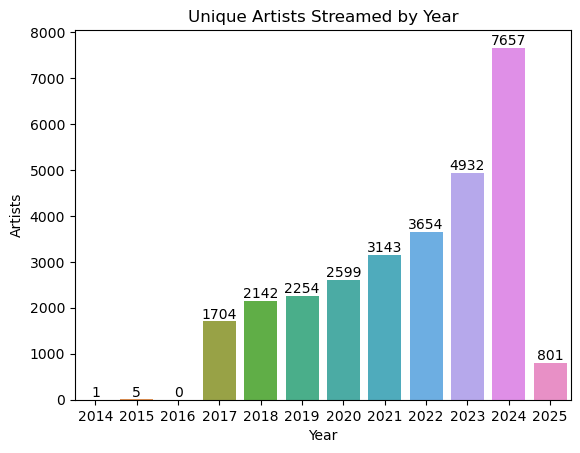

In [126]:
# Plot the barplot without error bars and with ordered categories
ax = sns.barplot(
    x="year_streamed", 
    y="unique_artist_count", 
    data=unique_artists_per_year_df, 
    errorbar=None,  # Disable error bars
    # order=weekdays_order  # Set the order of the days
)

# Set a bar label to show amounts
ax.bar_label(ax.containers[0], fontsize=10);

# # Add title and labels for clarity
plt.title("Unique Artists Streamed by Year")
plt.xlabel("Year")
plt.ylabel("Artists")
plt.show()

I spent the first few years not listening to Spotify at all, or listening to the point the stream count was neglible, prior to there being large amounts of consistent streaming activity coupled with consistent year over year growth.

## Top Artists for Every Year

We will focus on obtaining the top 5 artists by stream count per year.

The `LATERAL` join is used to act as a "for loop," processing each distinct year individually. The query then orders the results by the year ascending and the stream count descending.

In [128]:
# Read in CSV for unique artists per year
top_5_artists_per_year_df = pd.read_csv(query_output_path / 'top_5_artists_per_year.csv')

In [139]:
top_5_artists_per_year_df.head()

,year_streamed,artist_name,ts_count
0,2014,Ron Basejam,1
1,2015,Lars Behrenroth,3
2,2015,Pelican,1
3,2015,Prof.Sakamoto,1
4,2015,Scott Walker,1


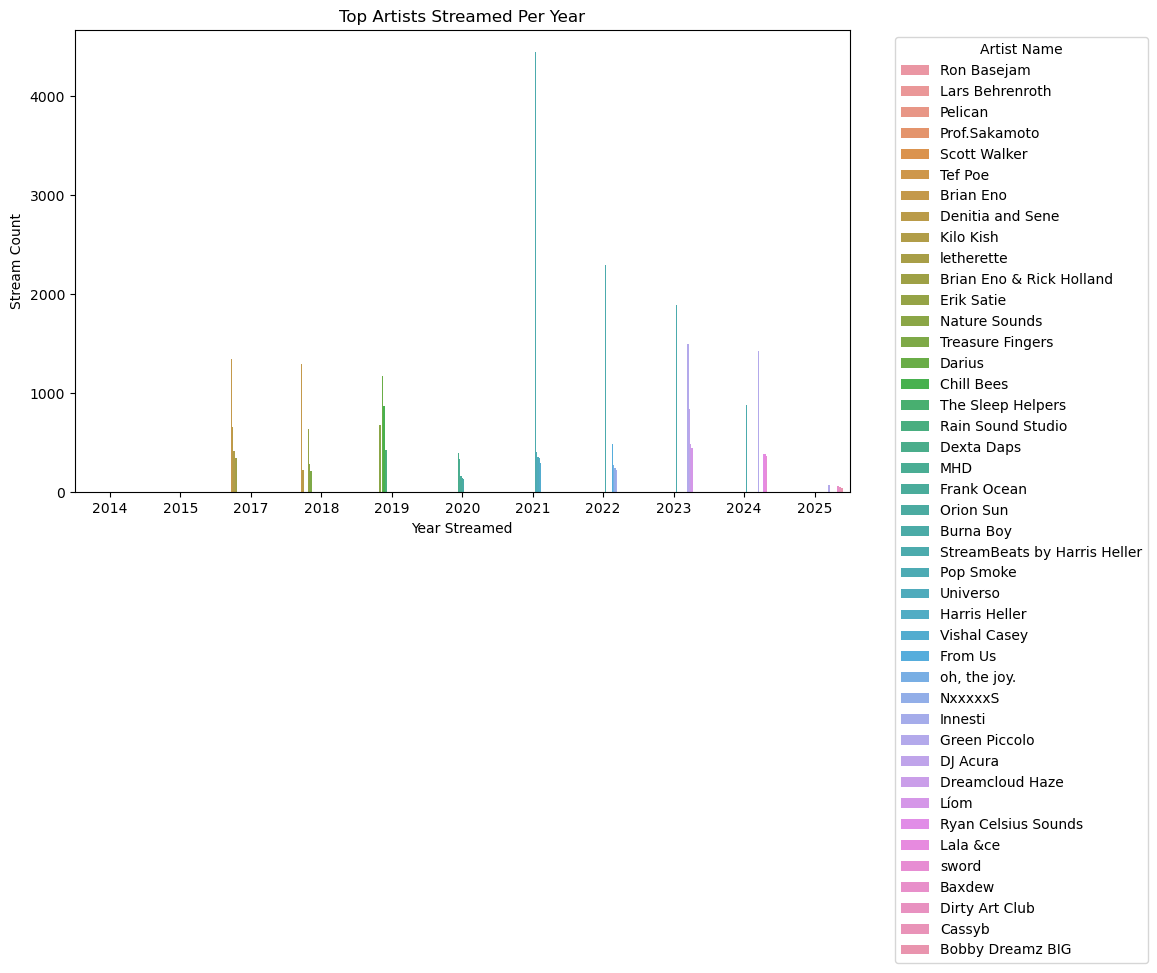

In [137]:
# Create the clustered column chart (grouped bar chart)
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_5_artists_per_year_df, x="year_streamed", y="ts_count", hue="artist_name", dodge=True)
# Labels and title
plt.xlabel("Year Streamed")
plt.ylabel("Stream Count")
plt.title("Top Artists Streamed Per Year")

# Show legendb outside
plt.legend(title="Artist Name", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

Since the above chart is nigh UNREADABLE, I will break this down year by year.

Index(['year_streamed', 'artist_name', 'ts_count'], dtype='object')


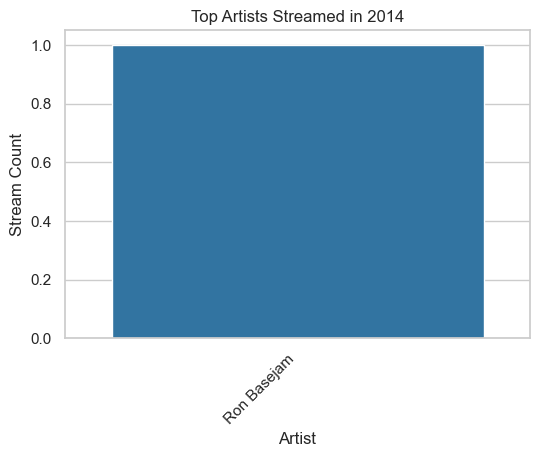

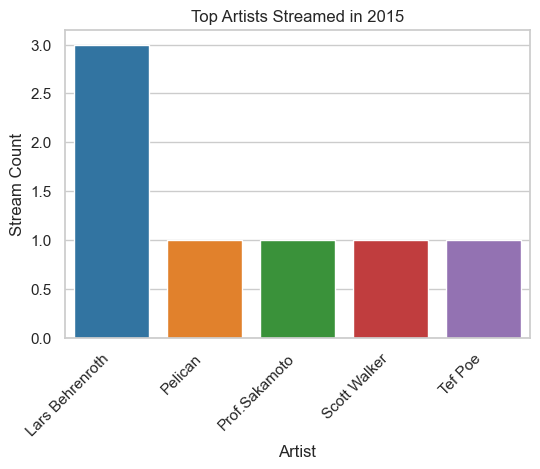

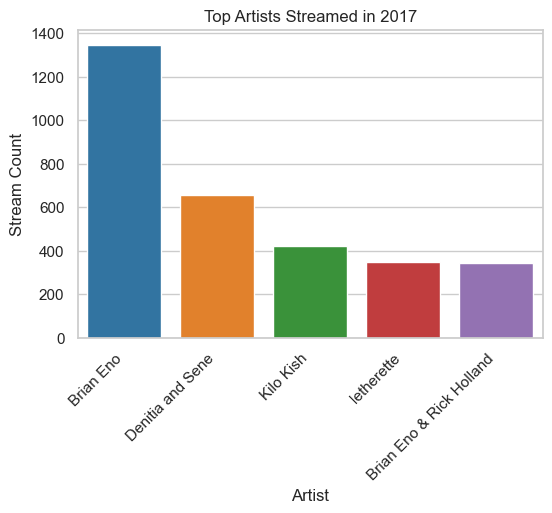

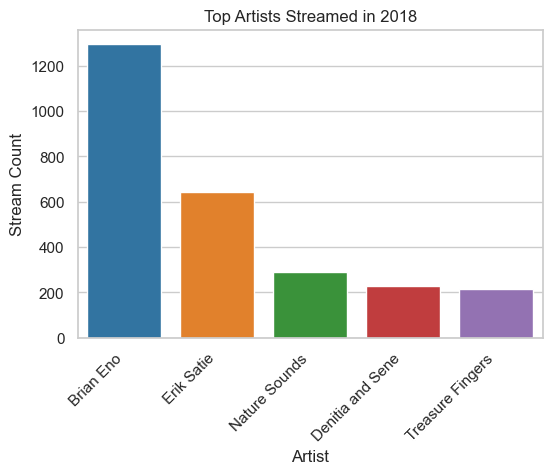

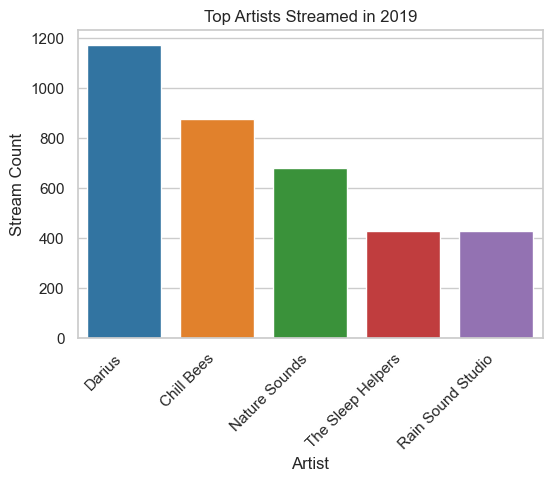

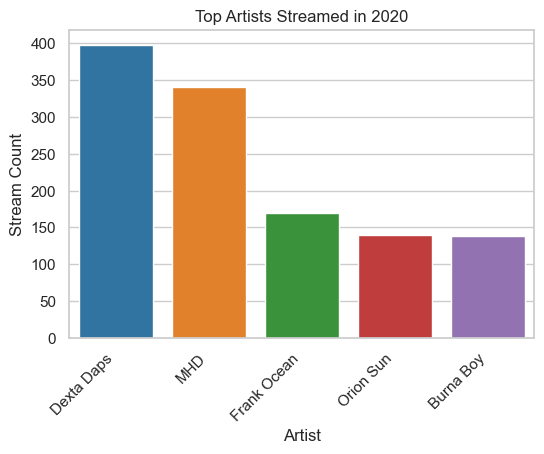

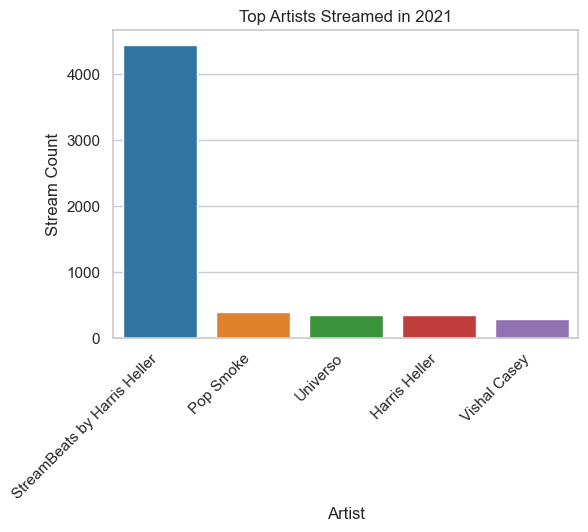

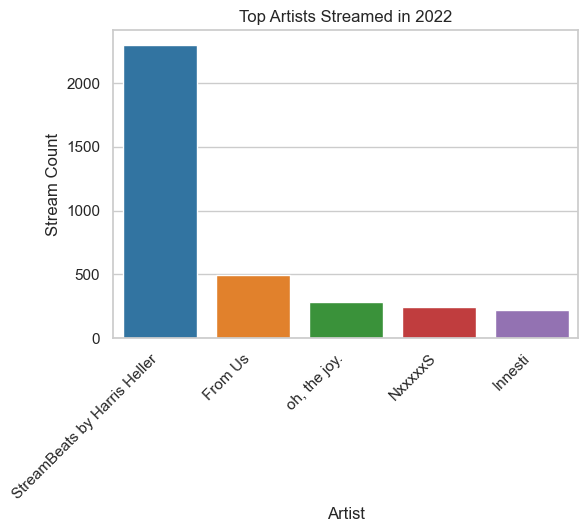

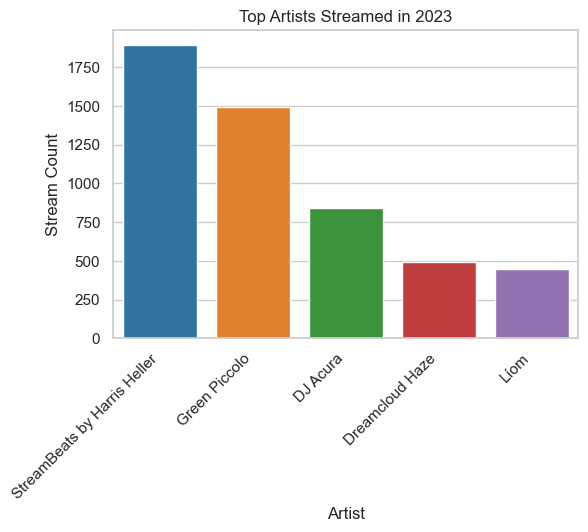

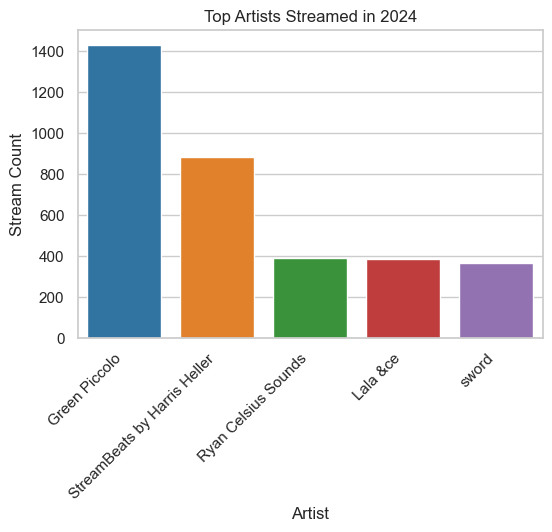

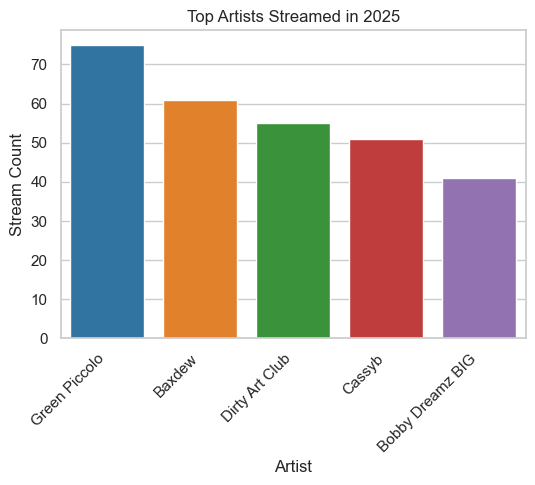

In [141]:
# 🛠 Ensure 'year_streamed' column exists and has no hidden spaces
top_5_artists_per_year_df.columns = top_5_artists_per_year_df.columns.str.strip()

# 🔄 Convert 'year_streamed' to integer type (just in case it's stored as string)
top_5_artists_per_year_df["year_streamed"] = top_5_artists_per_year_df["year_streamed"].astype(int)

# ✅ Re-run the print statement to confirm the column exists
print(top_5_artists_per_year_df.columns)  # Should output Index(['year_streamed', 'artist_name', 'ts_count'], dtype='object')

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# 🔄 Group data by year and plot separately
for year, group in top_5_artists_per_year_df.groupby("year_streamed"):
    plt.figure(figsize=(6, 4))  # Create a new figure for each plot
    ax = sns.barplot(data=group, x="artist_name", y="ts_count", palette="tab10")

    # Labels and title
    plt.xlabel("Artist")
    plt.ylabel("Stream Count")
    plt.title(f"Top Artists Streamed in {year}")

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha="right")

    # Show each plot separately in JupyterLab
    plt.show()

* **2014**: I have to admit, absolutely no idea who [Ron BaseJam](https://open.spotify.com/artist/3LijUg92GG1XomQ1OkuvfD?si=sVBmbJ62R3WraH4alt3pbA) is, but I appreciate the [track](https://open.spotify.com/track/04q4gmhv0YycumIlqGyEaF?si=ce2846681a1745b6) I had on heavy rotation this year; it has an older House Music vibe I'm into, though the vocals are sparse and it never carries over onto something more transcendent.
* **2015**:

In [144]:
top_5_artists_per_year_df.head()

,year_streamed,artist_name,ts_count
0,2014,Ron Basejam,1
1,2015,Lars Behrenroth,3
2,2015,Pelican,1
3,2015,Prof.Sakamoto,1
4,2015,Scott Walker,1


In [148]:
# Use duckDB to search our dataframe for artists in a list
top_artists_2015 = duckdb.sql("""SELECT * FROM top_5_artists_per_year_df
            WHERE year_streamed = 2015
            """).df()

# Grob a list of artist we can copy/pasta into queries
top_artists_2015['artist_name'].to_list()

['Lars Behrenroth', 'Pelican', 'Prof.Sakamoto', 'Scott Walker', 'Tef Poe']

## Milliseconds spent listening to the number 1 artists.

Since we have multiple years, we will scope this to a yearly time periods. Our method to isolate this can bulid on previous art:
1. Isolate the number one artist by streams, per year, for all years.
2. Aggregate all songs, solo or collaborative, including this artist.
3. Calculate the total streaming time in milliseconds and in a "human-readable" format.
4. Compare the total milliseconds streamed by the top artist versus the total amount of milliseconds stream for that year.

As we have calculate the top 5 artists by streams already, we need only select the most streamed artist per year from this data.)

In [150]:
# Read in CSV for unique artists per year
top_artists_per_year_df = pd.read_csv(query_output_path / 'top_artist_per_year.csv')
top_artists_per_year_df

,year_streamed,artist_name,ts_count
0,2014,Ron Basejam,1
1,2015,Lars Behrenroth,3
2,2017,Brian Eno,1348
3,2018,Brian Eno,1294
4,2019,Darius,1174
5,2020,Dexta Daps,398
6,2021,StreamBeats by Harris Heller,4442
7,2022,StreamBeats by Harris Heller,2297
8,2023,StreamBeats by Harris Heller,1895
9,2024,Green Piccolo,1430


Armed with dataframe and database, I feel lazy. I will use code in the notebook to generate statements I can copy/paste into my SQL query window for pgAdmin. Given that `Harris Heller` has attribution credits in other songs, we will hand-edit the generated queries for this term to just wildcard search for `%Harris Heller%`.

In [163]:
# https://stackoverflow.com/questions/16476924/how-can-i-iterate-over-rows-in-a-pandas-dataframe
for index, row in top_artists_per_year_df.iterrows():
    print("--", row['year_streamed'], row['artist_name'])
    print(f"""
SELECT DISTINCT date_part('year', timestamp_column) AS year_streamed, artist_name, SUM(ms_played) AS total_artist_ms_played
FROM spotify_data
WHERE artist_name ILIKE '%{row['artist_name']}%'
AND date_part('year', timestamp_column) = {row['year_streamed']}
GROUP BY year_streamed, artist_name;

SELECT date_part('year', timestamp_column) AS year, SUM(ms_played) AS total_ms_played
FROM spotify_data
WHERE date_part('year', timestamp_column) = {row['year_streamed']}
GROUP BY year
    """)

-- 2014 Ron Basejam

SELECT DISTINCT date_part('year', timestamp_column) AS year_streamed, artist_name, SUM(ms_played) AS total_artist_ms_played
FROM spotify_data
WHERE artist_name ILIKE '%Ron Basejam%'
AND date_part('year', timestamp_column) = 2014
GROUP BY year_streamed, artist_name;

SELECT date_part('year', timestamp_column) AS year, SUM(ms_played) AS total_ms_played
FROM spotify_data
WHERE date_part('year', timestamp_column) = 2014
GROUP BY year
    
-- 2015 Lars Behrenroth

SELECT DISTINCT date_part('year', timestamp_column) AS year_streamed, artist_name, SUM(ms_played) AS total_artist_ms_played
FROM spotify_data
WHERE artist_name ILIKE '%Lars Behrenroth%'
AND date_part('year', timestamp_column) = 2015
GROUP BY year_streamed, artist_name;

SELECT date_part('year', timestamp_column) AS year, SUM(ms_played) AS total_ms_played
FROM spotify_data
WHERE date_part('year', timestamp_column) = 2015
GROUP BY year
    
-- 2017 Brian Eno

SELECT DISTINCT date_part('year', timestamp_column) A

After executing each query, consolidating for artist collaborations per year, we now cleaned-in-Excel data from CSV.

In [178]:
# Read in CSV for unique artists per year
top_ms_played_per_year_df = pd.read_csv(query_output_path / 'total_ms_played_per_year.csv')
top_ms_played_per_year_df

,year,artist,total_ms_played,total_yearly_ms_played,total_hours_played,total_yearly_hours_played,percentage_of_total_ms_played
0,2014,Ron Basejam,345730,345730,0.009604,0.009604,100.000000
1,2015,Lars Behrenroth,459475,663391,0.012763,0.018428,69.261567
2,2017,Brian Eno,579718682,4138228419,16.103297,114.950789,14.008861
3,2018,Brian Eno,506806758,4229896391,14.077965,117.497122,11.981541
4,2019,Darius,251337405,7076043904,6.981595,196.556775,3.551948
5,2020,Dexta Daps,75273949,3750825773,2.090943,104.189605,2.006863
6,2021,StreamBeats by Harris Heller,639458707,8781943699,17.762742,243.942881,7.281517
7,2022,StreamBeats by Harris Heller,309252413,7931670459,8.590345,220.324179,3.898957
8,2023,StreamBeats by Harris Heller,258420940,7917803004,7.178359,219.938972,3.263796
9,2024,Green Piccolo,247078638,7219201694,6.863296,200.533380,3.422520


I observe an interesting set of "eras" in the top artists. [Ron Basejam](https://open.spotify.com/artist/3LijUg92GG1XomQ1OkuvfD?si=b-IE8_BrQGKzmQVKYI3BFQ) and [Lars Behrenroth](https://open.spotify.com/artist/7mvD9STpAXPlADKNQAYxFP?si=6zXmlYYTTdykdEvwxCZaww) being within the Dance/Electronic genres. The presence of Brian Eno and Darius seems a bit more atmospheric; both artists producting ambient, downtempo electronic music. Much less "danceable."  A hard pivot to Dancehall Reggae with Dexta Daps; I suspect I binge-listened to "Breaking News" due to the provocative lyrics and the story they told. 

Harris Heller's three years of heavy rotation was derived from my streaming career and needing to have music free from DMCA restrictions to use to add background to my streams; the genres produced by Harris Heller can vary, but I would generally use Lo-Fi or House Music. Green Piccolo is a Phonk artist from Europe, with that genre being an eclectic amalgam of African American music across several different decades.


In [180]:
top_ms_played_per_year_df['total_hours_played'].describe()

count    11.000000
mean      7.275371
std       6.453293
min       0.009604
25%       1.224559
50%       6.981595
75%      11.334155
max      17.762742
Name: total_hours_played, dtype: float64

Quite surprised that the average time listening to a favorite artits is around *7.3* hours per year. The percentage of my total streaming time for a favorite artists falls in the range of *3.26%* and *3.90%* for the past four years. 

## Number of genres listened to for the year

This question is intriguing, as our data and research indicate that no genre information is bundled with individual tracks. Genre associations are tied to artists instead of songs. This design decision on Spotify's part seems efficient. You save columns of data bundling this with tracks and can likely infer what genre a song is by the artist. What this fails to account for is the possibility of artists potentially shifting or changing genres on a per-track basis. It may also be a challenge if songs have more than one collaborator, from a diverse genre, which may render deciding a song's genre even more challenging. Which artist's genre should take precedence in this scenario? Despite these corner cases, I suspect that Spotify felt the edge cases did not override the generalized ability to identify a song's genre based on the artist.

### Plan to Obtain Genres

1. Extract unique artists from current table into a new `artist` table.
2. Create a join table linking via the IDs for the `spotify_data` and the `artist` tables.
3. Using the `artist` table artist value, query the Spotify API to obtain the genres associated with each artist.
4. Using an array or appropriate structure, capture what genres are associated with each artist in a column in the `artist` field.

First we create our destination table `artists` using an array to store the list of multiple genres an artist may have, the artist name, and a unique ID for the table row. We also create an index to assist us later in searching for genres.

With the `artist` table created, we create a join table. 

Use a CTE to select the distinct artists and insert their names into our newly created table.

With the `artists` table populated, we must create join table to link the `artists` table to the `spotify_data` table. Since the only IDs we want must be base on these two existing tables, we set constraints on both `artists` and `spotify_data` tables first.

After this, we create our join table, reference both the `id` columns in `artists` and `spotify_data` table, as well as setting up a composite primary key.

With our stage set, we can now populate the `sd_artists_join` table with data from `artists` and `spotify_data` table. Since there may be NULL values in our `artists` table, we add an appropriate `WHERE` clause just in case.

Now that we have our join table linking `artists` and `spotify_data`, we need to populate the `artists` table with genre data. We must extract the artist's name, consult the Spotify API, download and insert the results for their respective genre's into the `genres` column.

### Query the `artists` Table

We must query our `artists` table and then iteratively obtain each artist's genres and insert back into the `artists` table. 

In [21]:
# Create a variable capturing the Postgres table that will store our loaded Spotify data.
metadata_obj = MetaData()
artists_table = Table('artists', metadata_obj, autoload_with=engine)

In [55]:
# Create a search for artists that lack any genres column data
select_artists_stmt = select(artists_table.c['id', 'artist_name']).where(artists_table.c.genres == None)
# select_artists_null_stmt = select(artists_table.c['id', 'artist_name']).where(artists_table.c.genres == '{}')

select_artists_null_stmt = select(
    artists_table.c.id,
    artists_table.c.artist_name
).where(
    and_(
        or_(
            artists_table.c.genres == '{}',           # Empty array
            artists_table.c.genres.is_(None)          # NULL
        ),
        artists_table.c.id <= 18880                    # Apply to all records by setting this 18880
    )
)

print("-- Find where artists.genre is NULL")
print(select_artists_stmt)
print()
print()
print("-- Find where artists.genre is NULL filtered by artists.ID")
print(select_artists_null_stmt)

-- Find where artists.genre is NULL
SELECT artists.id, artists.artist_name 
FROM artists 
WHERE artists.genres IS NULL


-- Find where artists.genre is NULL filtered by artists.ID
SELECT artists.id, artists.artist_name 
FROM artists 
WHERE (artists.genres = :genres_1 OR artists.genres IS NULL) AND artists.id <= :id_1


With all preparation out of the way, we now set about processing every artist present in the `artists` table via `select_artists_stmt`, accessing the API, then inserting their genre into the array column appropriately. We are conservative with the timing between API requests, so as not to exhaust our daily quota limits. If we become disconnected or the processing is halted by API quota limit, we restart insertion via filtering for the last processed `artists.id` value.

Due to an issue with API disconnection, we found it necessary to restart the 
Spotify API processing from a specific record onward. We modify the query to
filter out records below a specific ID number to resume data population.

In [ ]:
# Insert genres into artists table, delay 10 seconds between API requests, filtering for every ID in the table
insert_artists_genres(10, 18880)

### CTE to Join Data

With genres now present in the `artists` table, we can determine how many unique genres were listened to, partitioning by year.

Using a CTE, we "unnest" the genres from the `genres` column in the `artists` table, while joining with the `sd_artists_join` and `spotify_data` table, while also ensuring we do not count records that are null, empty, nor tracks that have not been played longer than 5 seconds (5000 ms).

After this, we use another CTE to generate distinct genres per year, which we subsequently aggregate via the `COUNT` function. We are not concerned with how often a genre appeared in a year, just that it appeared at all. We can then output each year and how many genres are present in our streaming history per year.

### Plot Unique Genre Counts Per Year

In [24]:
# Read in CSV for unique genre counts per year
unique_genre_count_per_year_df = pd.read_csv(query_output_path / 'unique_genre_count_per_year.csv')
unique_genre_count_per_year_df

,stream_year,unique_genre_count
0,2015,1
1,2017,281
2,2018,322
3,2019,322
4,2020,338
5,2021,348
6,2022,377
7,2023,426
8,2024,495
9,2025,87


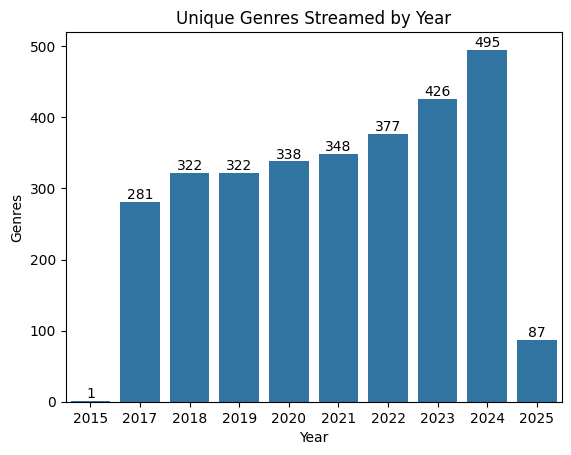

In [25]:
# Plot the barplot without error bars and with ordered categories
ax = sns.barplot(
    x="stream_year", 
    y="unique_genre_count", 
    data=unique_genre_count_per_year_df, 
    errorbar=None,  # Disable error bars
    # order=weekdays_order  # Set the order of the days
)

# Set a bar label to show amounts
ax.bar_label(ax.containers[0], fontsize=10);

# # Add title and labels for clarity
plt.title("Unique Genres Streamed by Year")
plt.xlabel("Year")
plt.ylabel("Genres")
plt.show()

A gradual increase in unique genres played per year, aside from the initial meteoric rise of me _actually_ using Spotify on a regular basis starting in **2017** and the partial data present for the year of **2025**.